In [ ]:
#@title imports for nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm

import numpy as np
from google.colab import files
import io

In [ ]:
#@title imports for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

In [ ]:
X = np.load('all_feed_forward_inputs.npy').astype('float32')
Y = np.load('binary_difficulty.npy').astype('int64')

In [ ]:
import numpy as np
import io
from google.colab import files
dummy_X = files.upload()
dummy_X = np.load(io.BytesIO(dummy_X['full_123_vectors.npy'])).astype('float32')
dummy_Y = files.upload()
dummy_Y = np.load(io.BytesIO(dummy_Y['full_123_labels.npy'])).astype('int64')

Saving full_123_vectors.npy to full_123_vectors (1).npy


Saving full_123_labels.npy to full_123_labels.npy


In [ ]:
## Different way of reading input vectors

X = files.upload()
X = np.load(io.BytesIO(X['all_feed_forward_inputs.npy'])).astype('float32')
Y = files.upload()
Y = np.load(io.BytesIO(Y['binary_difficulty.npy'])).astype('int64')

Saving all_feed_forward_inputs.npy to all_feed_forward_inputs.npy


Saving binary_difficulty.npy to binary_difficulty.npy


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


In [ ]:
### Wrapper function for training ffd network, if needed

def build_and_train(layer_sizes=[20,10], num_epochs=10, batch_size = None, learning_rate=0.01, folds=5, input_dim=43, output_dim=2, output_vector_size=2):
  layer_sizes = [input_dim]+layer_sizes+[output_dim]
  layer_list = []
  for l in range(len(layer_sizes)-1):
    layer_list.append(nn.Linear(layer_sizes[l],layer_sizes[l+1], bias=True))
    layer_list.append(nn.ReLU())
  
  model = nn.Sequential(*layer_list[:-1])
                  
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  kfold = KFold(n_splits=folds)

  valid_loss =  []
  valid_acc = []
  test_loss = []
  test_acc = []
  
  pbar = tqdm(total=num_epochs*folds)
  for epoch in range(num_epochs):
    avg_loss_lis = []
    avg_acc_lis = []
    avg_test_loss = []
    avg_test_acc = []
    for train_index, valid_index in kfold.split(x_train, y_train):  
      x_train_fold = x_train[train_index]
      y_train_fold = y_train[train_index]
      x_valid_fold = x_train[valid_index]
      y_valid_fold = y_train[valid_index] 

      # Training loop
      if batch_size is None:
        model.zero_grad()
        y_logits = model(x_train_fold)
        loss = criterion(y_logits, y_train_fold)
        loss.backward()
        optimizer.step()
      else:
        batch_indices = list(range(0,y_train_fold.shape[0],batch_size))
        for i in range(len(batch_indices)-1):
          model.zero_grad()
          y_logits = model(x_train_fold[batch_indices[i]:batch_indices[i+1]])
          loss = criterion(y_logits, y_train_fold[batch_indices[i]:batch_indices[i+1]])
          loss.backward()
          optimizer.step()
        model.zero_grad()
        y_logits = model(x_train_fold[batch_indices[-1]:])
        loss = criterion(y_logits, y_train_fold[batch_indices[-1]:])
        loss.backward()
        optimizer.step()
        


      # Training Validation
      yval_logits = model(x_valid_fold)
      yval_pred = torch.max(yval_logits,1)[1]
      v_loss = criterion(yval_logits, y_valid_fold)
      v_acc = torch.mean((yval_pred == y_valid_fold).type(torch.float))
      # valid_loss.append(v_loss.item())
      # valid_acc.append(v_acc)
      avg_loss_lis.append(v_loss.item())
      avg_acc_lis.append(v_acc)
      # Testing Validation
      ytest_logits = model(x_test)
      ytest_pred = torch.max(ytest_logits,1)[1]
      # if 0 < torch.sum(ytest_pred) and torch.sum(ytest_pred) < 101:
      #   raise Exception("Nuanced Predictions!")
      t_loss = criterion(ytest_logits, y_test)
      t_acc = torch.mean((ytest_pred == y_test).type(torch.float))
      # test_loss.append(t_loss.item())
      # test_acc.append(t_acc)
      avg_test_loss.append(t_loss.item())
      avg_test_acc.append(t_acc)

      pbar.update(1)
    valid_loss.append(sum(avg_loss_lis)/len(avg_loss_lis))
    valid_acc.append((sum(avg_acc_lis)/len(avg_acc_lis)))
    test_loss.append(sum(avg_test_loss)/len(avg_test_loss))
    test_acc.append(sum(avg_test_acc)/len(avg_test_acc))
  pbar.close()

  # x_axis = list(range(1, num_epochs*folds+1))
  x_axis = list(range(1, num_epochs+1))

  plt.figure()
  plt.plot(x_axis, valid_loss, label='xval loss')
  plt.plot(x_axis, test_loss, label='loss on test set')
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.title('learining rate = '+str(learning_rate))
  # plt.xticks(ticks=[e*folds for e in range(1,num_epochs+1)], labels=list(range(1,num_epochs+1)))
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(x_axis, valid_acc, label='xval prediction accuracy')
  plt.plot(x_axis, test_acc, label='prediction accuracy on test set')
  plt.ylabel("Prediction Accuracy")
  plt.xlabel("Epochs")
  plt.title('learining rate = '+str(learning_rate))
  # plt.xticks(ticks=[e*folds for e in range(1,num_epochs+1)], labels=list(range(1,num_epochs+1)))
  plt.legend()
  plt.show()



In [ ]:
### Wrapper function v2 for training ffd network, if needed

def build_and_train_v2(layer_sizes=[20,10], num_epochs=10, batch_size = None, learning_rate=0.01, folds=5, input_dim=43, output_dim=2, output_vector_size=2):
  layer_sizes = [input_dim]+layer_sizes+[output_dim]
  layer_list = []
  for l in range(len(layer_sizes)-1):
    layer_list.append(nn.Linear(layer_sizes[l],layer_sizes[l+1], bias=True))
    layer_list.append(nn.ReLU())
  
  model = nn.Sequential(*layer_list[:-1])
                  
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  valid_loss =  []
  valid_acc = []
  test_loss = []
  test_acc = []
  
  pbar = tqdm(total=num_epochs*folds)

  for epoch in range(num_epochs):
    avg_loss_lis = []
    avg_acc_lis = []
    avg_test_loss = []
    avg_test_acc = []
    for iteration in range(y_train.shape[0]):
      xi = x_train[iteration,:]
      yi = y_train[iteration]

      # Training loop
      if batch_size is None:
        model.zero_grad()
        y_logits = model(xi)
        loss = criterion(y_logits, yi)
        loss.backward()
        optimizer.step()
        avg_loss_lis.append(loss.item())
      else:
        batch_indices = list(range(0,y_train_fold.shape[0],batch_size))
        for i in range(len(batch_indices)-1):
          model.zero_grad()
          y_logits = model(x_train_fold[batch_indices[i]:batch_indices[i+1]])
          loss = criterion(y_logits, y_train_fold[batch_indices[i]:batch_indices[i+1]])
          loss.backward()
          optimizer.step()
        model.zero_grad()
        y_logits = model(x_train_fold[batch_indices[-1]:])
        loss = criterion(y_logits, y_train_fold[batch_indices[-1]:])
        loss.backward()
        optimizer.step()

      print("Epoch: ", epoch, "avg loss = ", sum(avg_loss_lis)/len(avg_loss_lis))
        


      # # Training Validation
      # yval_logits = model(x_valid_fold)
      # yval_pred = torch.max(yval_logits,1)[1]
      # v_loss = criterion(yval_logits, y_valid_fold)
      # v_acc = torch.mean((yval_pred == y_valid_fold).type(torch.float))
      # # valid_loss.append(v_loss.item())
      # # valid_acc.append(v_acc)
      # avg_loss_lis.append(v_loss.item())
      # avg_acc_lis.append(v_acc)
      # # Testing Validation
      # ytest_logits = model(x_test)
      # ytest_pred = torch.max(ytest_logits,1)[1]
      # # if 0 < torch.sum(ytest_pred) and torch.sum(ytest_pred) < 101:
      # #   raise Exception("Nuanced Predictions!")
      # t_loss = criterion(ytest_logits, y_test)
      # t_acc = torch.mean((ytest_pred == y_test).type(torch.float))
      # # test_loss.append(t_loss.item())
      # # test_acc.append(t_acc)
      # avg_test_loss.append(t_loss.item())
      # avg_test_acc.append(t_acc)

  #     pbar.update(1)
  #   valid_loss.append(sum(avg_loss_lis)/len(avg_loss_lis))
  #   valid_acc.append((sum(avg_acc_lis)/len(avg_acc_lis)))
  #   test_loss.append(sum(avg_test_loss)/len(avg_test_loss))
  #   test_acc.append(sum(avg_test_acc)/len(avg_test_acc))
  # pbar.close()

  # # x_axis = list(range(1, num_epochs*folds+1))
  # x_axis = list(range(1, num_epochs+1))

  # plt.figure()
  # plt.plot(x_axis, valid_loss, label='xval loss')
  # plt.plot(x_axis, test_loss, label='loss on test set')
  # plt.ylabel("Loss")
  # plt.xlabel("Epochs")
  # plt.title('learining rate = '+str(learning_rate))
  # # plt.xticks(ticks=[e*folds for e in range(1,num_epochs+1)], labels=list(range(1,num_epochs+1)))
  # plt.legend()
  # plt.show()

  # plt.figure()
  # plt.plot(x_axis, valid_acc, label='xval prediction accuracy')
  # plt.plot(x_axis, test_acc, label='prediction accuracy on test set')
  # plt.ylabel("Prediction Accuracy")
  # plt.xlabel("Epochs")
  # plt.title('learining rate = '+str(learning_rate))
  # # plt.xticks(ticks=[e*folds for e in range(1,num_epochs+1)], labels=list(range(1,num_epochs+1)))
  # plt.legend()
  # plt.show()



100%|██████████| 100/100 [00:00<00:00, 321.69it/s]


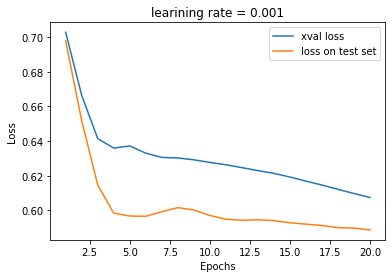

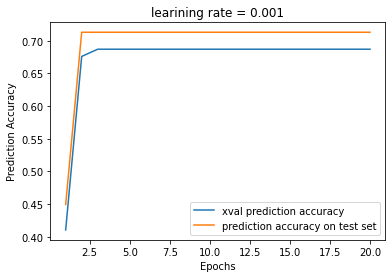

In [ ]:
#Epochs: 10, 50, 100, 500, 1000
#lr: .1, .01, .001
# layer_sizes=[40,20,10]

build_and_train(layer_sizes=[40,20], num_epochs = 20, learning_rate=0.001)

In [ ]:
def draw_field(length=105, width=68):
    """
    Draws a soccer field given its length and width
    """
    color_dict={'pitch': 'w','lines': 'silver','ball': 'k'}
    #Setting up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots(figsize = (length/7, width/7))
    ax.set_xlim(( -3, length+3))
    ax.set_ylim((-3, width+3))
    
      
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #Plotting the Soccer Field
    ax.set_facecolor(color_dict['pitch'])#Grass
    ax.plot([length/2,length/2],[0,width],color_dict['lines']) #half-way line
    ax.plot([0,0],[0,width],color_dict['lines'])
    ax.plot([length,length],[0,width],color_dict['lines'])
    ax.plot([0,length],[0,0],color_dict['lines'])
    ax.plot([0,length],[width,width],color_dict['lines'])


    ax.add_artist(plt.Circle((length/2,width/2), 9.15, edgecolor=color_dict['lines'],facecolor = None, fill=False)) #centre circle
    ax.add_artist(plt.Circle((length/2,width/2), 0.3, edgecolor=color_dict['lines'],facecolor = color_dict['lines'])) #centre spot


    #Penalty boxes
    ax.plot([16.5,16.5],[width/2-16.5-7.3/2,width/2+16.5+7.3/2],color_dict['lines'])
    ax.plot([length-16.5,length-16.5],[width/2-16.5-7.3/2,width/2+16.5+7.3/2],color_dict['lines'])
    ax.plot([5.5,5.5],[width/2-5.5-7.3/2,width/2+5.5+7.3/2],color_dict['lines'])
    ax.plot([length-5.5,length-5.5],[width/2-5.5-7.3/2,width/2+5.5+7.3/2],color_dict['lines'])
    ax.plot([0,16.5],[width/2-16.5-7.3/2,width/2-16.5-7.3/2],color_dict['lines'])
    ax.plot([length-16.5,length],[width/2-16.5-7.3/2,width/2-16.5-7.3/2],color_dict['lines'])
    ax.plot([0,16.5],[width/2+16.5+7.3/2,width/2+16.5+7.3/2],color_dict['lines'])
    ax.plot([length-16.5,length],[width/2+16.5+7.3/2,width/2+16.5+7.3/2],color_dict['lines'])
    ax.plot([0,5.5],[width/2-5.5-7.3/2,width/2-5.5-7.3/2],color_dict['lines'])
    ax.plot([length-5.5,length],[width/2-5.5-7.3/2,width/2-5.5-7.3/2],color_dict['lines'])
    ax.plot([0,5.5],[width/2+5.5+7.3/2,width/2+5.5+7.3/2],color_dict['lines'])
    ax.plot([length-5.5,length],[width/2+5.5+7.3/2,width/2+5.5+7.3/2],color_dict['lines'])
    ax.add_patch(mpl.patches.Arc((11,width/2),19,19,theta1=-53.0, theta2=53.0, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))
    ax.add_patch(mpl.patches.Arc((length-11,width/2),19,19,theta1=53.0+74, theta2=-53.0-74, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))
    ax.add_artist(plt.Circle((11,width/2), 0.4, edgecolor=color_dict['lines'],facecolor = color_dict['lines'])) #penalty spot
    ax.add_artist(plt.Circle((length-11,width/2), 0.4, edgecolor=color_dict['lines'],facecolor = color_dict['lines'])) #penalty spot

    ax.add_patch(mpl.patches.Arc((length,width),height=1,width=1,theta1=180,theta2=270, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))
    ax.add_patch(mpl.patches.Arc((length,0),height=1,width=1,theta1=90,theta2=180, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))
    ax.add_patch(mpl.patches.Arc((0,width),height=1,width=1,theta1=270,theta2=0, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))
    ax.add_patch(mpl.patches.Arc((0,0),height=1,width=1,theta1=0,theta2=90, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))

    #Left Goal
    ax.plot([-2.44,-2.44],[width/2-7.3/2,width/2+7.3/2],color_dict['lines'])
    ax.plot([-2.44,0],[width/2-7.3/2,width/2-7.3/2],color_dict['lines'])
    ax.plot([-2.44,0],[width/2+7.3/2,width/2+7.3/2],color_dict['lines'])

    #Right Goal
    ax.plot([length+2.44,length+2.44],[width/2-7.3/2,width/2+7.3/2],color_dict['lines'])
    ax.plot([length,length+2.44],[width/2-7.3/2,width/2-7.3/2],color_dict['lines'])
    ax.plot([length,length+2.44],[width/2+7.3/2,width/2+7.3/2],color_dict['lines'])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    return fig, ax

In [ ]:
def offside_situation_plotter(scenario_vectors, length=105, width=68):
    color_dict={'attack': 'red', 'defense': 'blue', 'ref': 'black', 'passer': 'orange'}
    # can take a single 1-D vector as well
    # if a 2D matrix of scenario vectors is passed in, makes an approximated heatmap
    if scenario_vectors.ndim == 1:
      scenario_vectors = np.expand_dims(scenario_vectors.copy(),0)
    assert scenario_vectors.shape[1] == 43
    n = scenario_vectors.shape[0]
    if n == 1:
      player_size = 100
    else:
      player_size = 100

    def x_transform(x): # undoes normalization during vectorization process
      return x*length
    def y_transform(y):
      return y*(width+2)-1

    # Draw field
    fig, ax = draw_field(length, width)

    # separate x and y coordinate sets
    ref_xcoord, ref_ycoord, passer_xcoord, passer_ycoord, attack_xcoord, attack_ycoord, defense_xcoord, defense_ycoord = [],[],[],[],[],[],[],[]

    for scenario_vector in scenario_vectors:

      ### Divide into team vectors
      ref_xcoord.append(x_transform(scenario_vector[0]))
      ref_ycoord.append(y_transform(1))
      passer_xcoord.append(x_transform(scenario_vector[1]))
      passer_ycoord.append(y_transform(scenario_vector[2]))
      remaining_attack = scenario_vector[3:21] 
      defense = scenario_vector[21:43]  

      for i in range(len(remaining_attack)):
        if i%2==0:
          attack_xcoord.append(x_transform(remaining_attack[i]))
        if i%2==1:
          attack_ycoord.append(y_transform(remaining_attack[i]))

      for i in range(len(defense)):
        if i%2==0:
          defense_xcoord.append(x_transform(defense[i]))
        if i%2==1:
          defense_ycoord.append(y_transform(defense[i]))

    assert ((len(attack_xcoord)==len(attack_ycoord)) and (len(defense_xcoord)==len(defense_ycoord)))

    # Plot linesman
    # for i in range(len(ref_xcoord)):
    #   ax.scatter(ref_xcoord[i], ref_ycoord[i], color=color_dict['ref'], s=player_size)
    # Plot passer
    # for i in range(len(passer_xcoord)):
    #   ax.scatter(passer_xcoord[i], passer_ycoord[i], color=color_dict['passer'], s=player_size)
    # Plot defending team
    for i in range(len(defense_xcoord)):
      ax.scatter(defense_xcoord[i],defense_ycoord[i],color=color_dict['defense'], s=player_size)
    # Plot attacking team
    # for i in range(len(attack_xcoord)):
    #   ax.scatter(attack_xcoord[i],attack_ycoord[i],color=color_dict['attack'], s=player_size)

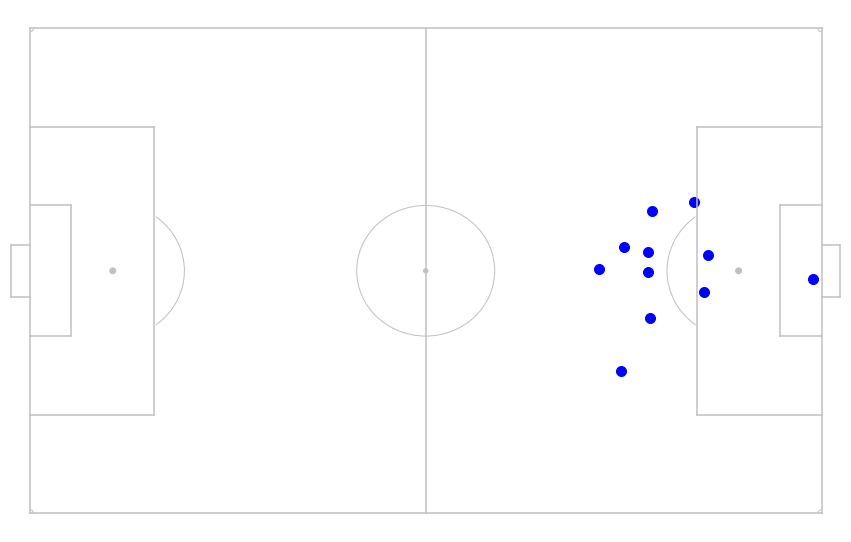

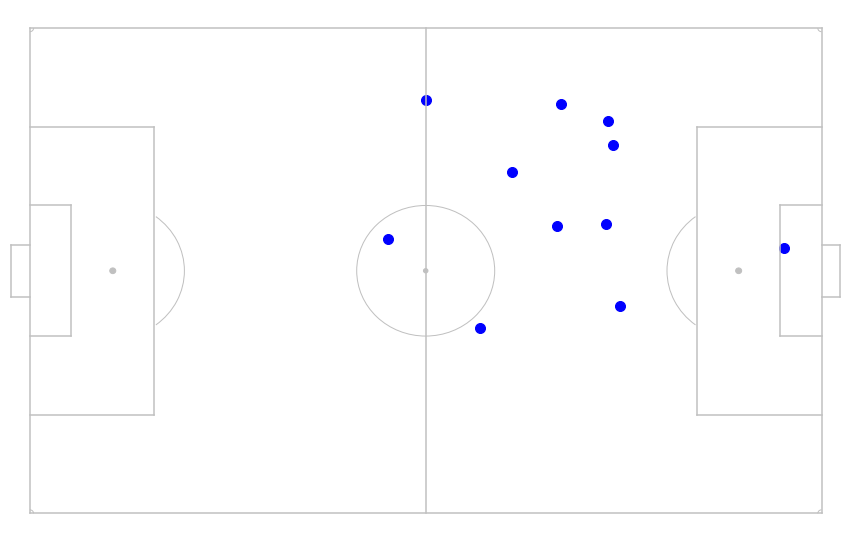

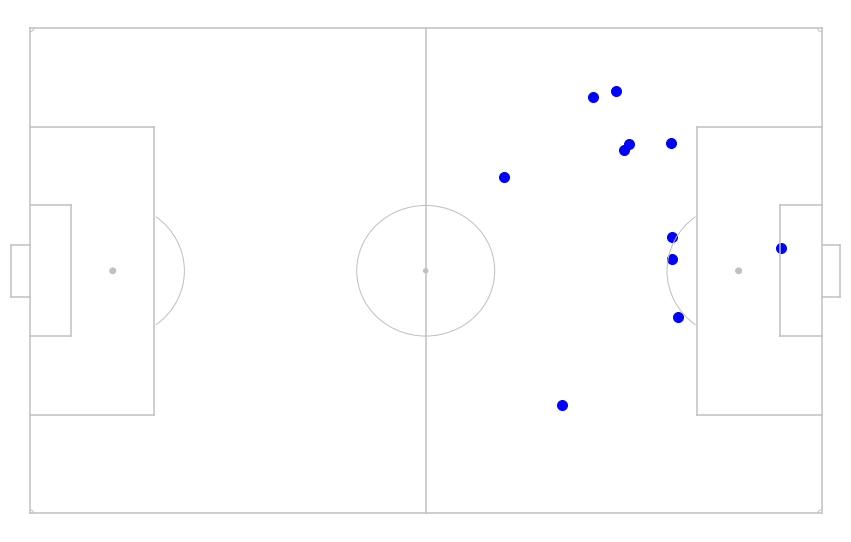

In [ ]:
for i in [0,1,3]:
  offside_situation_plotter(dummy_X[dummy_Y == 2][i])

In [ ]:
def scenario_heatmap(scenario_vectors, length=105, width=68):
  # takes numpy array of scenario vectors
  assert scenario_vectors.shape[1] == 43

  # step 1: preparing simple pandas dataframe with x_pos, y_pos, and team
  def x_transform(x): # undoes normalization during vectorization process
    return x*length
  def y_transform(y):
    return y*(width+2)-1
  columns = ["x", "y", "team"]
  rows = []
  for scenario_vector in scenario_vectors:
    ref_x = x_transform(scenario_vector[0])
    ref_y = y_transform(1)
    passer_x = x_transform(scenario_vector[1])
    passer_y = y_transform(scenario_vector[2])
    rows.append((ref_x, ref_y, "linesman"))
    rows.append((passer_x, passer_y, "passer"))

    remaining_attack = scenario_vector[3:21] 
    defense = scenario_vector[21:43]  

    # separate x and y coordinate sets
    attack_xcoord, attack_ycoord, defense_xcoord, defense_ycoord = [],[],[],[]

    for i in range(len(remaining_attack)):
      if i%2==0:
        attack_xcoord.append(x_transform(remaining_attack[i]))
      if i%2==1:
        attack_ycoord.append(y_transform(remaining_attack[i]))
    assert len(attack_xcoord)==len(attack_ycoord)
    for i in range(len(attack_xcoord)):
      #if attack_xcoord[i] > passer_x:
        rows.append((attack_xcoord[i], attack_ycoord[i], "attack"))

    for i in range(len(defense)):
      if i%2==0:
        defense_xcoord.append(x_transform(defense[i]))
      if i%2==1:
        defense_ycoord.append(y_transform(defense[i]))
    assert len(defense_xcoord)==len(defense_ycoord)
    for i in range(len(defense_xcoord)):
      #if defense_xcoord[i] > passer_x:
        rows.append((defense_xcoord[i], defense_ycoord[i], "defense"))
  data = pd.DataFrame(rows, columns=columns)
  # Draw field
  fig, ax = draw_field(length, width)
  ax.set_title("attacking team locations")
  # Draw heatmap
  sns.kdeplot(
    data=data[data["team"] == "attack"], x="x", y="y", ax=ax, fill=True
  )
  # Draw field
  fig, ax = draw_field(length, width)
  ax.set_title("defending team locations")
  # Draw heatmap
  sns.kdeplot(
    data=data[data["team"] == "defense"], x="x", y="y", ax=ax, fill=True
  )
  # Draw field
  fig, ax = draw_field(length, width)
  ax.set_title("passing player locations")
  # Draw heatmap
  sns.kdeplot(
    data=data[data["team"] == "passer"], x="x", y="y", ax=ax, fill=True
  )



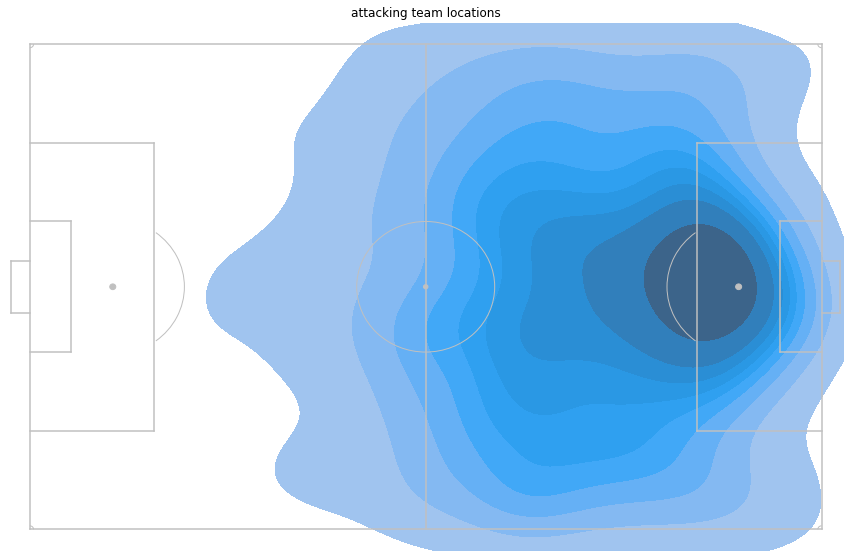

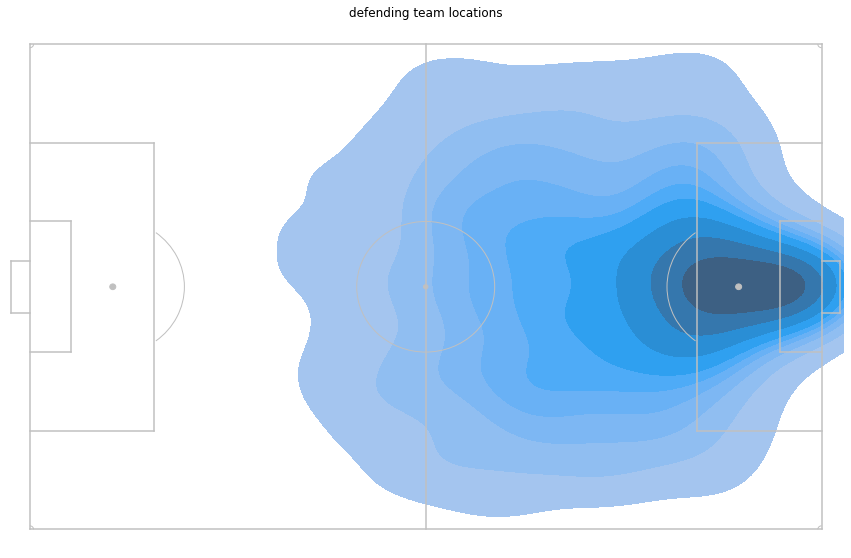

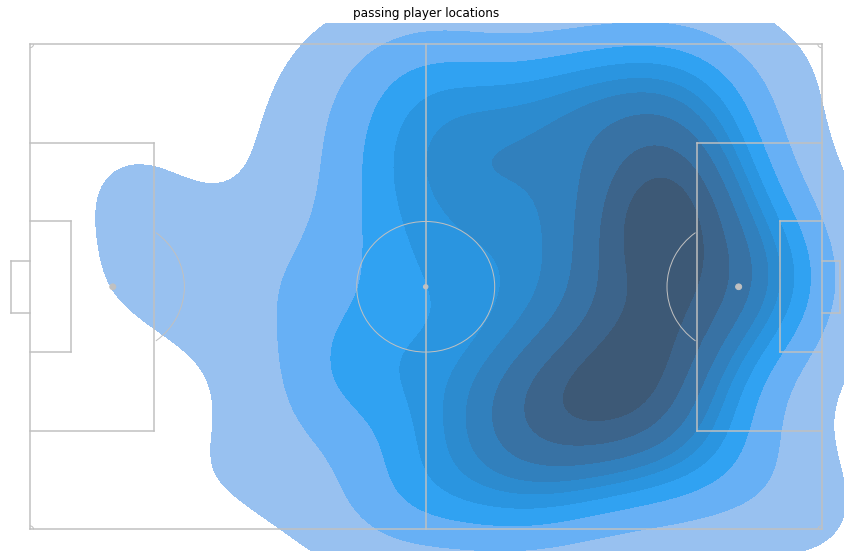

In [ ]:
scenario_heatmap(X[Y==1])

In [ ]:
vectors_for_clustering = files.upload()
vectors_for_clustering = np.load(io.BytesIO(vectors_for_clustering['vectors_for_clustering.npy']))

Saving vectors_for_clustering.npy to vectors_for_clustering.npy


In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(vectors_for_clustering)

(<Figure size 1080x699.429 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5acd73be10>)

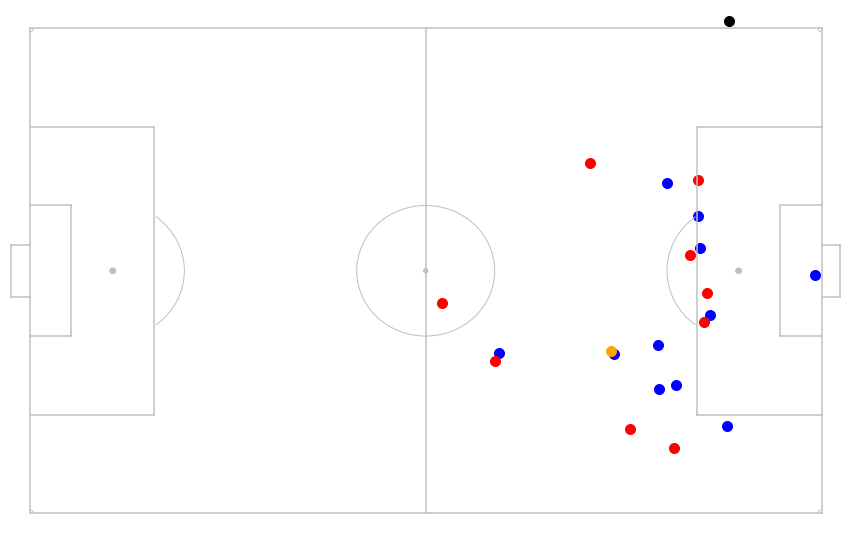

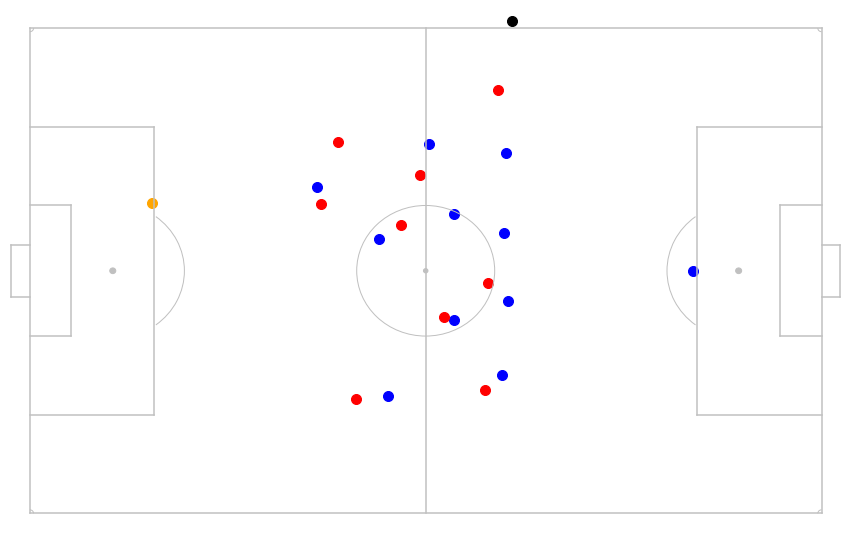

In [ ]:
offside_situation_plotter(vectors_for_clustering[100])
offside_situation_plotter(vectors_for_clustering[200])

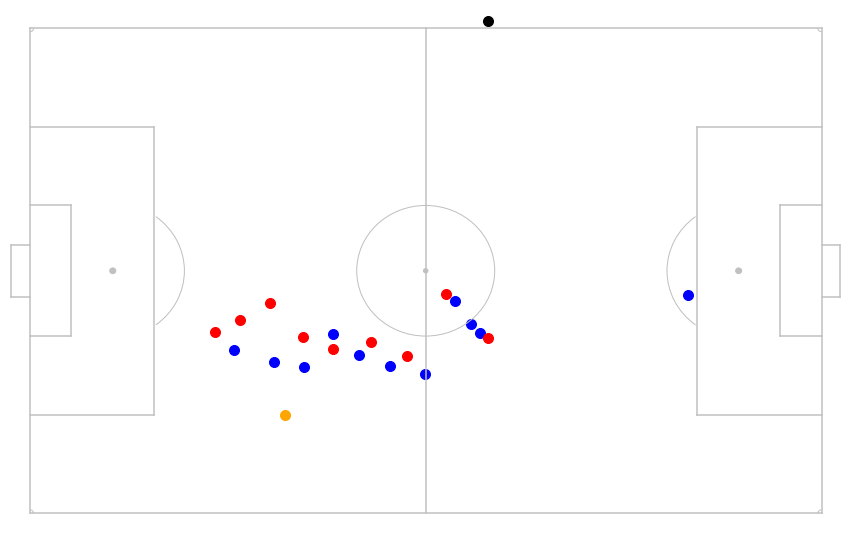

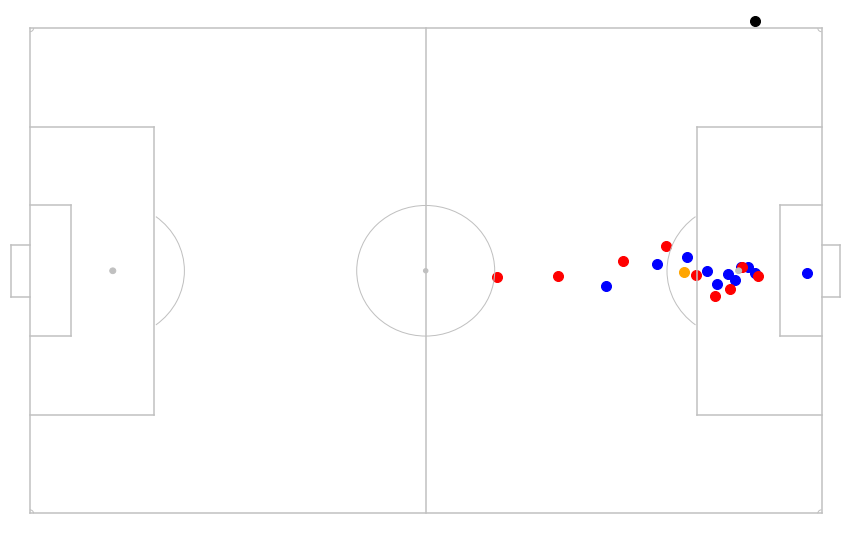

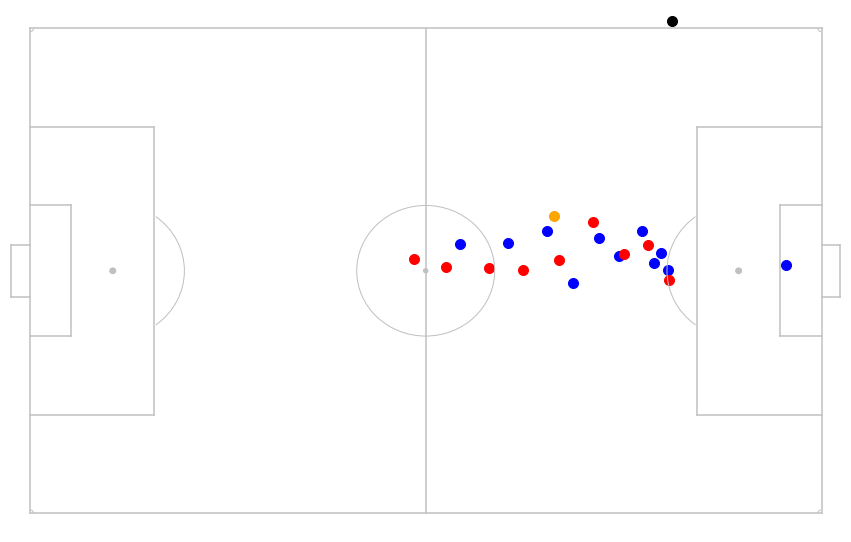

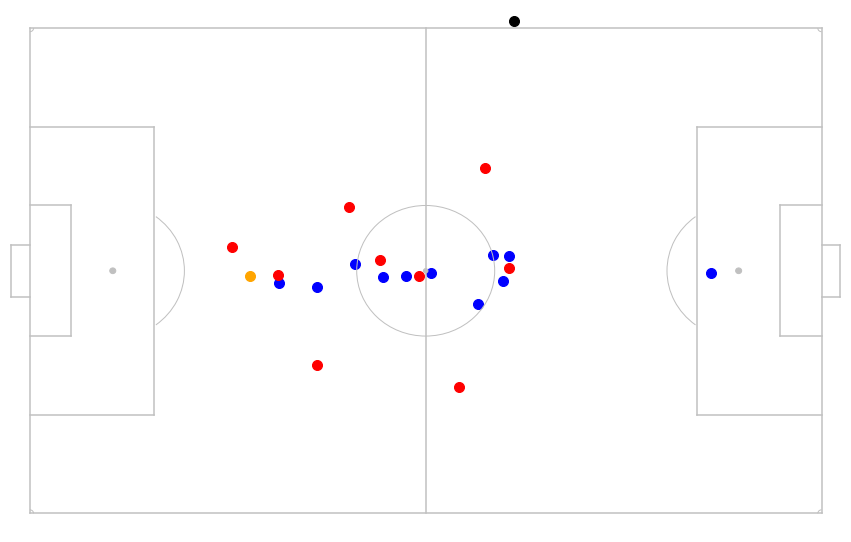

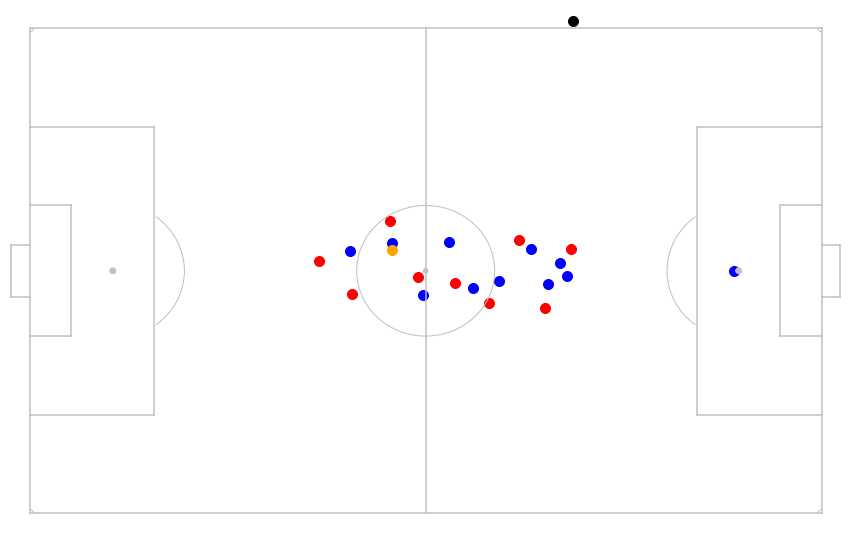

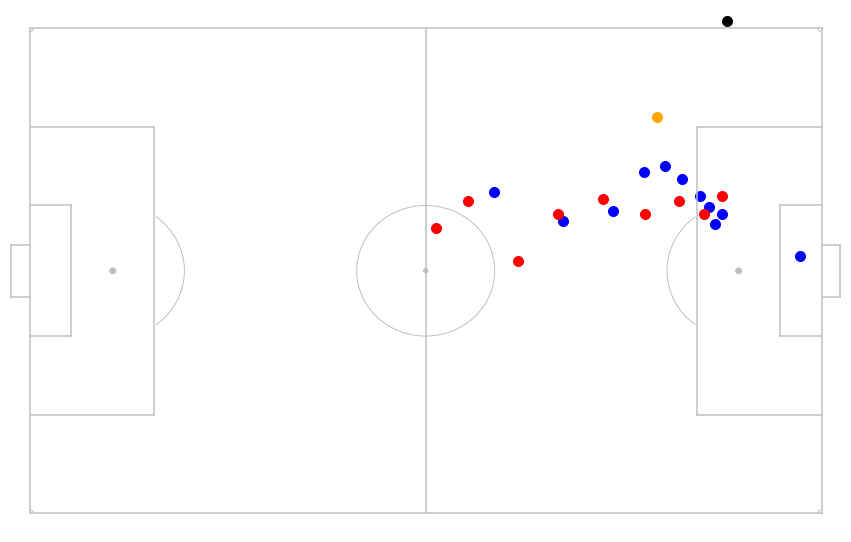

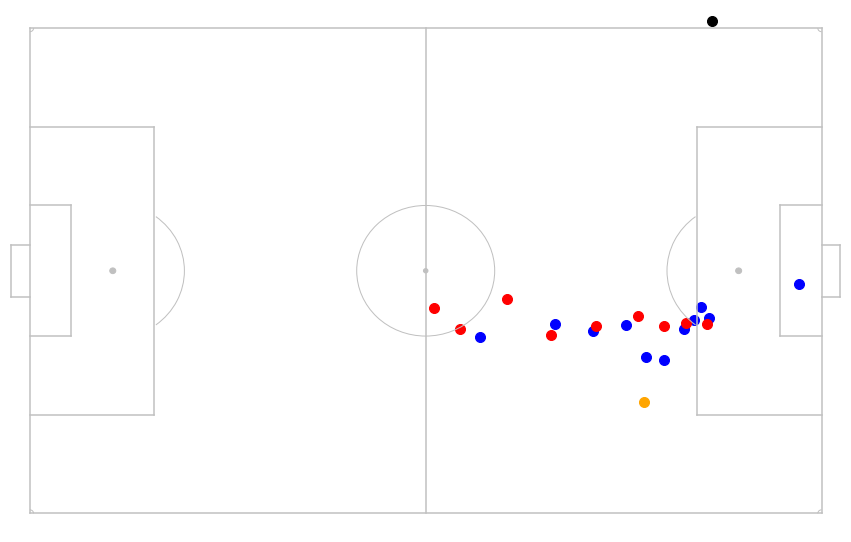

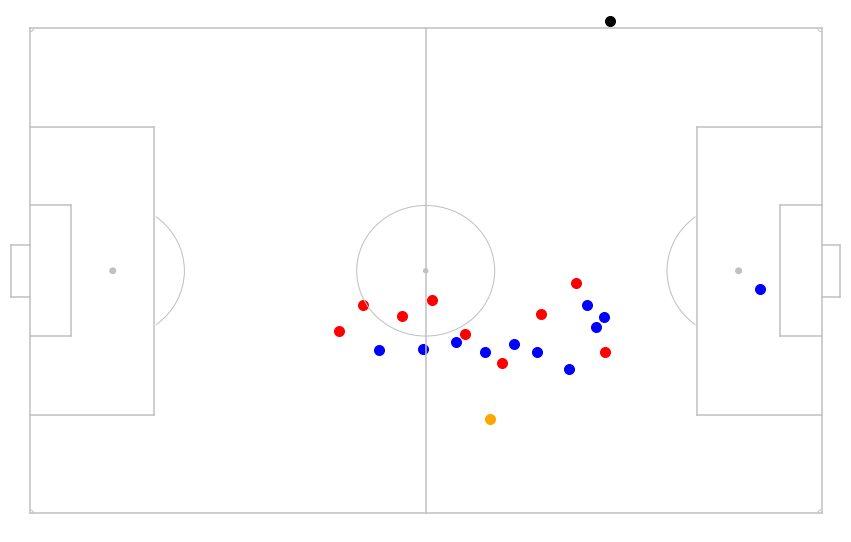

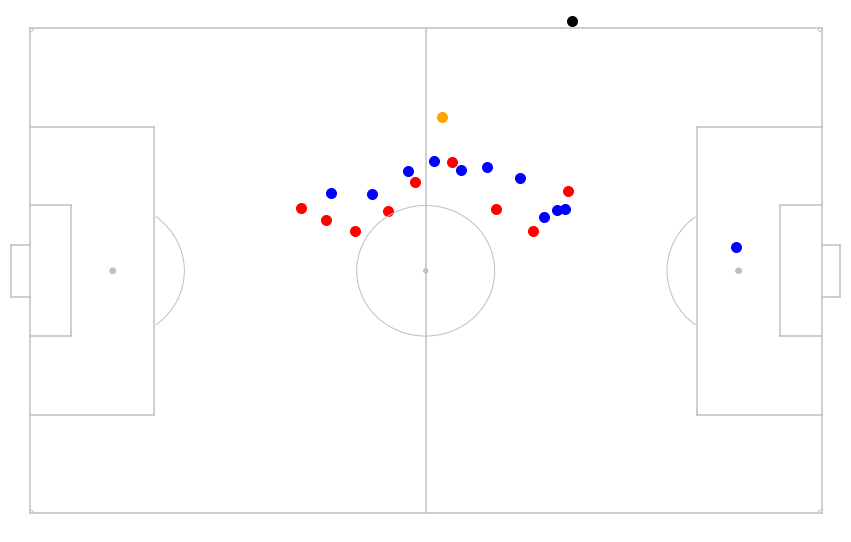

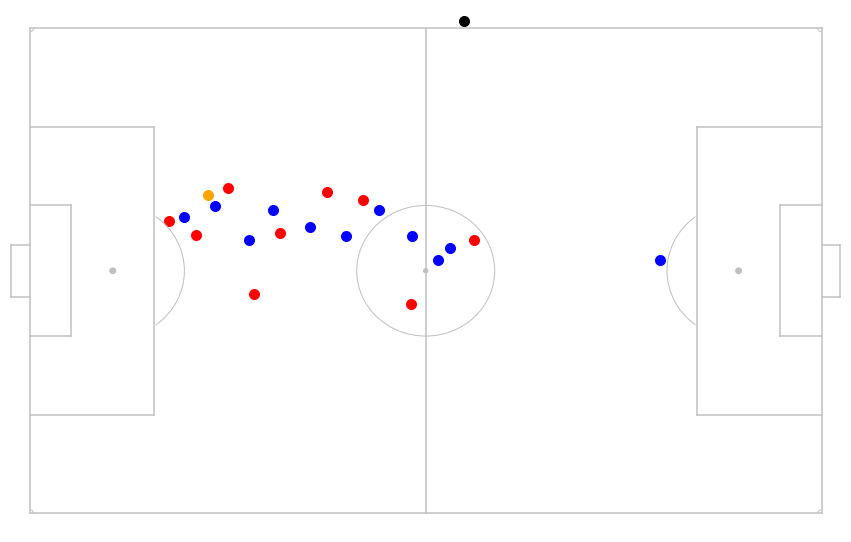

In [ ]:
for center in kmeans.cluster_centers_:
  offside_situation_plotter(center)